<a href="https://colab.research.google.com/github/CHGROSJEAN/2024_MLEES/blob/main/Projet/Projet_Charlotte_Grosjean_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import libraries and data


Frist step, simple GMM for 2 stations : Grand-Vennes and Riand-Pré.

In [33]:
# Import
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import os
from shapely.geometry import Point
from sklearn.metrics import silhouette_score

from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE





Download data sets

In [2]:
# Reading the Excel files
grandvennes = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/GrandVennes.xlsx")
riandpre = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/RiandPre.xlsx")
chandieu = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Chandieu.xlsx")
geopolis = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Geopolis.xlsx")
lexplore = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/LExplore.xlsx")
bethusy = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Bethusy.xlsx")
boisgentils = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/BoisGentils.xlsx")
elysee = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Elysee.xlsx")
pontaise = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Pontaise.xlsx")
rouvraie = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Rouvraie.xlsx")
vclb = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/VersChezLesBlancs.xlsx")




DateTime ajustment

In [3]:
# Ensuring the 'DateTime' the column is of datetime type for both datasets
grandvennes['DateTime'] = pd.to_datetime(grandvennes['DateTime'], dayfirst=True)
riandpre['DateTime'] = pd.to_datetime(riandpre['DateTime'], dayfirst=True)
chandieu['DateTime'] = pd.to_datetime(chandieu['DateTime'], dayfirst=True)
geopolis['DateTime'] = pd.to_datetime(geopolis['DateTime'], dayfirst=True)
lexplore['DateTime'] = pd.to_datetime(lexplore['DateTime'], dayfirst=True)
bethusy['DateTime'] = pd.to_datetime(bethusy['DateTime'], dayfirst=True)
boisgentils['DateTime'] = pd.to_datetime(boisgentils['DateTime'], dayfirst=True)
elysee['DateTime'] = pd.to_datetime(elysee['DateTime'], dayfirst=True)
pontaise['DateTime'] = pd.to_datetime(pontaise['DateTime'], dayfirst=True)
rouvraie['DateTime'] = pd.to_datetime(rouvraie['DateTime'], dayfirst=True)
vclb['DateTime'] = pd.to_datetime(vclb['DateTime'], dayfirst=True)



# Setting the DateTime column as the index for easier time-based operations
grandvennes.set_index('DateTime', inplace=True)
riandpre.set_index('DateTime', inplace=True)
chandieu.set_index('DateTime', inplace=True)
geopolis.set_index('DateTime', inplace=True)
lexplore.set_index('DateTime', inplace=True)
bethusy.set_index('DateTime', inplace=True)
boisgentils.set_index('DateTime', inplace=True)
elysee.set_index('DateTime', inplace=True)
pontaise.set_index('DateTime', inplace=True)
rouvraie.set_index('DateTime', inplace=True)
vclb.set_index('DateTime', inplace=True)

Aligning all station to be merged in 1 dataset

In [4]:
# Round down the DateTime to the previous minute (removes seconds, truncating)
grandvennes.index = grandvennes.index.floor('min')  # rounded to the nearest lower minute
riandpre.index = riandpre.index.floor('min')
bethusy.index = bethusy.index.floor('min')
boisgentils.index = boisgentils.index.floor('min')
chandieu.index = chandieu.index.floor('min')
elysee.index = elysee.index.floor('min')
lexplore.index = lexplore.index.floor('min')
pontaise.index = pontaise.index.floor('min')
rouvraie.index = rouvraie.index.floor('min')
vclb.index = vclb.index.floor('min')
geopolis.index = geopolis.index.floor('min')

# Resample both datasets to ensure they have data every 3 minutes (if necessary)
# Resampling to the closest 3-minute interval and filling missing values with NaN
grandvennes_resampled = grandvennes.resample('3min').mean()
riandpre_resampled = riandpre.resample('3min').mean()
bethusy_resampled = bethusy.resample('3min').mean()
boisgentils_resampled = boisgentils.resample('3min').mean()
chandieu_resampled = chandieu.resample('3min').mean()
elysee_resampled = elysee.resample('3min').mean()
lexplore_resampled = lexplore.resample('3min').mean()
pontaise_resampled = pontaise.resample('3min').mean()
rouvraie_resampled = rouvraie.resample('3min').mean()
vclb_resampled = vclb.resample('3min').mean()
geopolis_resampled = geopolis.resample('3min').mean()


# Align both datasets to the common time period (intersection of their timestamps)
start_time = max(grandvennes_resampled.index.min(), riandpre_resampled.index.min(),bethusy_resampled.index.min(),
                 boisgentils_resampled.index.min(),chandieu_resampled.index.min(),elysee_resampled.index.min(), lexplore_resampled.index.min(),
                 pontaise_resampled.index.min(),rouvraie_resampled.index.min(),vclb_resampled.index.min(),geopolis_resampled.index.min())


end_time = min(grandvennes_resampled.index.max(), riandpre_resampled.index.max(), bethusy_resampled.index.max(),
               boisgentils_resampled.index.max(),chandieu_resampled.index.max(),elysee_resampled.index.max(),lexplore_resampled.index.max(),
               pontaise_resampled.index.max(),rouvraie_resampled.index.max(),vclb_resampled.index.max(),geopolis_resampled.index.max())

grandvennes_aligned = grandvennes_resampled.loc[start_time:end_time]
riandpre_aligned = riandpre_resampled.loc[start_time:end_time]
bethusy_aligned = bethusy_resampled.loc[start_time:end_time]
boisgentils_aligned = boisgentils_resampled.loc[start_time:end_time]
chandieu_aligned = chandieu_resampled.loc[start_time:end_time]
elysee_aligned = elysee_resampled.loc[start_time:end_time]
lexplore_aligned = lexplore_resampled.loc[start_time:end_time]
pontaise_aligned = pontaise_resampled.loc[start_time:end_time]
rouvraie_aligned = rouvraie_resampled.loc[start_time:end_time]
vclb_aligned = vclb_resampled.loc[start_time:end_time]
geopolis_aligned = geopolis_resampled.loc[start_time:end_time]

# Drop rows with missing values from both datasets
grandvennes_aligned = grandvennes_aligned.dropna()
riandpre_aligned = riandpre_aligned.dropna()
bethusy_aligned = bethusy_aligned.dropna()
boisgentils_aligned = boisgentils_aligned.dropna()
chandieu_aligned = chandieu_aligned.dropna()
elysee_aligned = elysee_aligned.dropna()
lexplore_aligned = lexplore_aligned.dropna()
pontaise_aligned = pontaise_aligned.dropna()
rouvraie_aligned = rouvraie_aligned.dropna()
vclb_aligned = vclb_aligned.dropna()
geopolis_aligned = geopolis_aligned.dropna()


Merging all stations datasets in 1 dataset

In [5]:
# Merge the datasets on the 'DateTime' index
combined_data = pd.concat(
    [
        grandvennes_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Grandvennes'}),
        riandpre_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Riandpre'}),
        bethusy_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Bethusy'}),
        boisgentils_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Boisgentils'}),
        chandieu_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Chandieu'}),
        elysee_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Elysee'}),
        lexplore_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Lexplore'}),
        pontaise_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Pontaise'}),
        rouvraie_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Rouvraie'}),
        vclb_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_VCLB'}),
        geopolis_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Geopolis'})
    ],
    axis=1,
    join='inner'  # Ensures alignment on shared indices only
)

# Display the first few rows of the combined data
print("Combined Precipitation Data:")
print(combined_data.head())
print(combined_data.shape)



Combined Precipitation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0                        0.0   
2023-01-19 14:

# OneClass SVM model

Standardize the data

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_data)

Split the dataset

Only in training and test sets because we are going to use Cross-Validation to tune the Hyperparameter

In [10]:
# Calculate the index for the splits
train_size = int(0.85 * len(X_scaled))  # 85% for training
test_size = len(combined_data) - train_size  # 15% for testing

# Split the data sequentially
train_data = combined_data[:train_size]
test_data = combined_data[train_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())

Training set size: 48555
Test set size: 8569

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0             

In [14]:
# Extract X for each dataset
# For training data
X_train_valid = train_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre', 'Precipitation_Bethusy', 'Precipitation_Boisgentils', 'Precipitation_Chandieu', 'Precipitation_Elysee', 'Precipitation_Lexplore', 'Precipitation_Pontaise', 'Precipitation_Rouvraie', 'Precipitation_VCLB', 'Precipitation_Geopolis']]  # Features (precipitation from both stations)

# For test data
X_test = test_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre', 'Precipitation_Bethusy', 'Precipitation_Boisgentils', 'Precipitation_Chandieu', 'Precipitation_Elysee', 'Precipitation_Lexplore', 'Precipitation_Pontaise', 'Precipitation_Rouvraie', 'Precipitation_VCLB', 'Precipitation_Geopolis']]  # Features (precipitation from both stations)

# Display the first few rows of the extracted data
print("X_train:")
print(X_train.head())

print("\nX_test:")
print(X_test.head())

X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0                        0.0   
2023-01-19 14:15:00               

In [16]:
# Calculate the index for the splits
train_size = int(0.8 * len(X_train_valid))  # 85% for training
Valid_size = len(X_train_valid) - train_size  # 15% for validation

# Split the data sequentially
X_train = X_train_valid[:train_size]
X_valid = X_train_valid[train_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(X_train)}")
print(f"Valid set size: {len(X_valid)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(X_train.head())

print("\nValid Data:")
print(X_valid.head())

Training set size: 38844
Valid set size: 9711

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0            

**Cross-Validation with Hyperparameter Tuning**

In [17]:
svm_test = OneClassSVM(kernel='rbf', nu=0.05, gamma=0.1)
svm_test.fit(scaler.transform(X_train))

OneClassSVM(gamma=0.1, nu=0.05)

In [18]:
svm_train_predict = svm_test.predict(scaler.transform(X_train))

In [19]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (svm_train_predict == -1).mean()
print(f"Fraction of train data classified as outliers: {fraction_outliers:.2%}")


Fraction of train data classified as outliers: 4.98%


In [25]:
# Convert predictions to cluster labels (e.g., map -1 to 0 for clarity)
cluster_labels = (svm_train_predict == 1).astype(int)  # Inliers as 1, Outliers as 0

# Compute Silhouette Score using transformed data
score = silhouette_score(scaler.transform(X_train), cluster_labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.9055112345227462


In [20]:
svm_valid_predict = svm_test.predict(scaler.transform(X_valid))

In [ ]:
scorer.__call__

<bound method _BaseScorer.__call__ of make_scorer(fraction_outliers, greater_is_better=False, response_method='predict')>

In [22]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (svm_valid_predict == -1).mean()
print(f"Fraction of train data classified as outliers: {fraction_outliers:.2%}")

Fraction of train data classified as outliers: 2.17%


In [28]:
# Convert predictions to cluster labels (e.g., map -1 to 0 for clarity)
cluster_labels_valid = (svm_valid_predict == 1).astype(int)  # Inliers as 1, Outliers as 0

# Compute Silhouette Score using transformed data
score_valid = silhouette_score(scaler.transform(X_valid), cluster_labels_valid)
print(f"Silhouette Score: {score_valid}")

Silhouette Score: 0.9517780235282819


In [23]:
svm_test_predict = svm_test.predict(scaler.transform(X_test))

In [24]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (svm_test_predict == -1).mean()
print(f"Fraction of train data classified as outliers: {fraction_outliers:.2%}")

Fraction of train data classified as outliers: 24.72%


In [30]:
# Convert predictions to cluster labels (e.g., map -1 to 0 for clarity)
cluster_labels_test = (svm_test_predict == 1).astype(int)  # Inliers as 1, Outliers as 0

# Compute Silhouette Score using transformed data
score_test = silhouette_score(scaler.transform(X_test), cluster_labels_test)
print(f"Silhouette Score: {score_test}")

Silhouette Score: 0.6396710934646661


In [ ]:
# Transform data into a lower-dimensional space
# Option 1: t-SNE
embedded_data = TSNE(n_components=2, random_state=42).fit_transform(scaler.transform(X_train))

# Option 2: UMAP (install: pip install umap-learn)
# embedded_data = umap.UMAP(n_components=2, random_state=42).fit_transform(scaler.transform(X_test))

# Map predictions to colors: inliers (1) vs outliers (-1)
colors = ['red' if label == -1 else 'blue' for label in svm_train_predict]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=colors, alpha=0.6)
plt.title("t-SNE/UMAP Visualization of Anomalies")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [ ]:
decision_scores = svm_test.decision_function(scaler.transform(X_train))

# Histogram of decision scores
plt.figure(figsize=(10, 6))
plt.hist(decision_scores, bins=50, color='gray', alpha=0.7, label='All Samples')
plt.axvline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title("Histogram of Decision Scores")
plt.xlabel("Decision Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Line plot (if data has temporal context, e.g., time-series)
plt.figure(figsize=(12, 6))
plt.plot(decision_scores, label='Decision Score', color='blue', alpha=0.6)
plt.scatter(range(len(svm_train_predict)), decision_scores, c=['red' if label == -1 else 'blue' for label in svm_train_predict], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title("Decision Scores Across Samples")
plt.xlabel("Sample Index")
plt.ylabel("Decision Score")
plt.legend()
plt.show()


# Cross validation

**Cross validation V1**

In [31]:
# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', OneClassSVM())
])

# Define hyperparameters to tune
param_grid = {
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__nu': [0.01, 0.05, 0.1 ],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}


def scorer_f_balanced(estimator, X_train):
    predictions = estimator.predict(X_train)
    fraction_outliers = (predictions == -1).mean()  # Calculate fraction of outliers
    raw_score_mean = np.mean(estimator.score_samples(X_train))  # Mean score
    # Penalize excessive outliers (e.g., fraction > expected threshold of 10%)
    penalty = max(0, fraction_outliers - 0.1) * 10  # Adjust weight as needed
    return raw_score_mean + penalty

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipe,
    param_grid,
    scoring=scorer_f_balanced,  # Define scoring
    cv=3,            # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,
    error_score = "raise" # Use all available processors
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train)

# Get best hyperparameters from GridSearchCV
print("Best hyperparameters found: ", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

**Cross validation V2**

In [ ]:
# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', OneClassSVM())
])

# Define hyperparameters to tune
param_grid = {
    'svm__kernel': ['rbf', 'linear'],
    'svm__nu': [0.01, 0.05, 0.1 ],
    'svm__gamma': [0.001, 0.01, 0.1]
}


def scorer_f_balanced(estimator, X_train):
    predictions = estimator.predict(X_train)
    fraction_outliers = (predictions == -1).mean()  # Calculate fraction of outliers
    raw_score_mean = np.mean(estimator.score_samples(X_train))  # Mean score
    return -abs(fraction_outliers - 0.1)  # Score closer to 10% fraction

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipe,
    param_grid,
    scoring=scorer_f_balanced,  # Define scoring
    cv=3,            # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,
    error_score = "raise" # Use all available processors
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train)

# Get best hyperparameters from GridSearchCV
print("Best hyperparameters found: ", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)





Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best hyperparameters found:  {'svm__gamma': 0.01, 'svm__kernel': 'rbf', 'svm__nu': 0.1}
Best Score: -0.03729403269218145


In [ ]:
# Retrieve the best model from GridSearchCV
best_model = grid_search.best_estimator_

In [ ]:
#Train the best model on the full training dataset
best_model.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', OneClassSVM(gamma=0.01, nu=0.1))])

In [ ]:
train_predictions = best_model.predict(X_train)

In [ ]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (train_predictions == -1).mean()
print(f"Fraction of train data classified as outliers: {fraction_outliers:.2%}")


Fraction of train data classified as outliers: 92.94%


In [ ]:
# Evaluate the model on the test data
# Predict anomalies (-1 for anomalies, 1 for normal)
test_predictions = best_model.predict(X_test)

In [ ]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (test_predictions == -1).mean()
print(f"Fraction of test data classified as outliers: {fraction_outliers:.2%}")


Fraction of test data classified as outliers: 88.33%


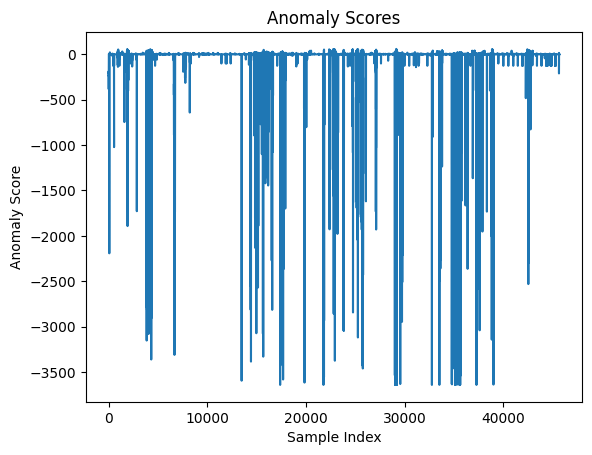

In [ ]:
# Compute decision function values (reconstructed scores)
scores = best_model.decision_function(X_train)

# Plot the anomaly scores
plt.plot(scores)
plt.title('Anomaly Scores')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.show()


In [ ]:
# Calculate MAE and RMSE
mae = mean_absolute_error(X_train, scores)
rmse = np.sqrt(mean_squared_error(X_train, scores))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

ValueError: y_true and y_pred have different number of output (11!=1)

In [ ]:
# Compute decision function values (reconstructed scores)
scores = best_model.decision_function(X_test)

# Calculate MAE and RMSE
mae = mean_absolute_error(X_test, scores)
rmse = np.sqrt(mean_squared_error(X_test, scores))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
# Ensure clustering metrics receive valid inputs (labels must be >= 0)
cluster_labels = np.where(train_predictions == -1, 0, 1)  # Map -1 to 0 for anomalies

# Compute Silhouette Score
sil_score = silhouette_score(X_train, cluster_labels)

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(X_train, cluster_labels)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")

In [ ]:
# Ensure clustering metrics receive valid inputs (labels must be >= 0)
cluster_labels = np.where(test_predictions == -1, 0, 1)  # Map -1 to 0 for anomalies

# Compute Silhouette Score
sil_score = silhouette_score(X_test, cluster_labels)

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(X_test, cluster_labels)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")